In [1]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

Using TensorFlow backend.


In [2]:
model = unet()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [3]:
# import glob
# import cv2 as cv
# import numpy as np
# X_train=[]
# #for filename in glob.glob("./data/membrane/train/aug/train/*.jpg"):
# for i in range(100):
#     # print (filename)
#     x = cv.imread(filename)
#     img = np.zeros([3,480,640])
#     img[0,:,:]=x[:,:,0]
#     img[1,:,:]=x[:,:,1]
#     img[2,:,:]=x[:,:,2]
#     # print(np.array(img).shape,np.array(x).shape)
#     X_train.append(img)
# X_train = np.asarray(X_train)


In [15]:
import cv2 as cv
import random
def generate_arrays_from_file(batch_size):
    while(True):
        X_train=[]
        y_train=[]
        for i in range(batch_size):
            num = random.randint(0,899)
            x = cv.imread("./data/membrane/train/aug/train/%d.jpg"%(num))
            x = cv.resize(x,(128,128))
            x = x / 255
            y = cv.imread("./data/membrane/train/aug/label/%d.jpg"%(num),0)
            y = cv.resize(y,(128,128))
            y = 1*(y>100) 
            x = x.reshape(128,128,3)
            y = y.reshape(128,128,1)
            X_train.append(x)
            y_train.append(y)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        yield(X_train,y_train)

In [16]:
model.fit_generator(generate_arrays_from_file(20),
        steps_per_epoch=50,nb_epoch=50)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, steps_per_epoch=50)`
  


Epoch 1/50
50/50 [==============================] - 804s 16s/step - loss: 0.0883 - acc: 0.9828
Epoch 2/50
50/50 [==============================] - 794s 16s/step - loss: 0.0913 - acc: 0.9826
Epoch 3/50
50/50 [==============================] - 795s 16s/step - loss: 0.0704 - acc: 0.9823
Epoch 4/50
50/50 [==============================] - 795s 16s/step - loss: 0.0483 - acc: 0.9823
Epoch 5/50
50/50 [==============================] - 795s 16s/step - loss: 0.0426 - acc: 0.9822
Epoch 6/50
50/50 [==============================] - 795s 16s/step - loss: 0.0396 - acc: 0.9830
Epoch 7/50
50/50 [==============================] - 794s 16s/step - loss: 0.0389 - acc: 0.9823
Epoch 8/50
50/50 [==============================] - 794s 16s/step - loss: 0.0386 - acc: 0.9823
Epoch 9/50
50/50 [==============================] - 794s 16s/step - loss: 0.0367 - acc: 0.9828
Epoch 10/50
50/50 [==============================] - 794s 16s/step - loss: 0.0367 - acc: 0.9828
Epoch 11/50
50/50 [==============================

In [18]:
y = cv.imread("./data/membrane/train/aug/label/%d.jpg"%(5),0)
y = cv.resize(y,(128,128))
y = 255*( y > 100 )
#y=y.reshape(480,640,1)

In [19]:
x = cv.imread("./data/membrane/train/aug/train/%d.jpg"%(5),1)
x = cv.resize(x,(128,128))
#x = x.reshape(480,640,1)

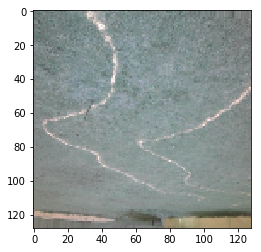

In [22]:
import matplotlib.pyplot as plt
plt.imshow(x)

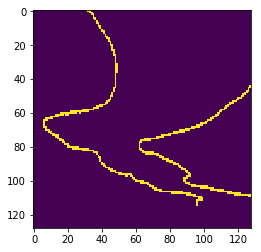

In [23]:
plt.imshow(y)

In [24]:
model.save_weights("model.h5")

In [31]:
y=model.predict(x.reshape(1,128,128,3))

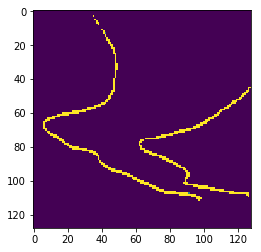

In [32]:
plt.imshow(y.reshape(128,128)*255)

In [36]:
t=y.reshape(128,128)*255

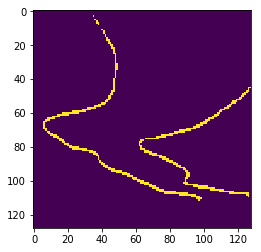

In [40]:
plt.imshow(t>130)